Ring dangle dongle slamb dampgus.

In [2]:
from osgeo import ogr
import numpy as np
import os
import pandas as pd
import math
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import colorsys

plt.rcParams['agg.path.chunksize'] = 1000
os.chdir('/home/joseph/Dev/python_projects/gerrymandering/NewHampshire/HarvardData/')
stateSHORT = "NH"

In [2]:
""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
"""   make a  list of all voting tabulation districts   """
""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
def features(layer):
    features = []
    for feat in layer: 
        features.append( feat )
    return features


""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
"""   total distance for a list of points in lat/long   """
""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
def ToFeet(listofpoints):
    R = 3961 * 5280
    x = np.asarray([point[0] for point in listofpoints])
    y = np.asarray([point[1] for point in listofpoints])

    dlon = (y[1:] - y[:-1])
    dlat = (x[1:] - x[:-1])
    a = (np.sin(math.pi * 0.5*dlat/180.0))**2 +  np.cos(math.pi*x[1:]/180.0) *  np.cos(math.pi*x[:-1]/180.0) * (np.sin(math.pi*0.5*dlon/180.0))**2
    c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) )
    d = R * sum( c )
    return d


""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
"""  create a lookup table of adjacencies between vtds  """
""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
def adjacencies(mylistoffeatures):
    l1 = list()
    l2 = list()
    for count in range(len(mylistoffeatures)):
        f1 = mylistoffeatures[count]
        if stateSHORT == 'PA':
            name = str(f1['GEOID10']) + f1['NAME10']
        elif stateSHORT == 'NH':
            name = str(f1['GEOID10'])
        g1 = f1.geometry()
        for f2 in mylistoffeatures[count+1:]:
            g2 = f2.geometry()
            if g1.Touches(g2):
                l1.append(name)
                if stateSHORT == 'PA':
                    l2.append(str(f2['GEOID10']) + f2['NAME10'])
                elif stateSHORT == 'NH':
                    l2.append(str(f2['GEOID10']))
    newthing = pd.DataFrame(np.column_stack((np.array(l1), np.array(l2))))
    newthing.columns=['lo','hi']
    return newthing


""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
"""  create a lookup dict boundaries as lat/long lists  """
""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
def boundaries(mylistoffeatures):
    boundaries = {}
    for feat in mylistoffeatures:
        geom = feat.geometry()
        gtype = geom.GetGeometryType()

        if gtype == 6: 
            x = []
            y = []
            for i in xrange(geom.GetGeometryCount()):
                g = geom.GetGeometryRef(i)
                for ring in g:
                    for j in xrange(ring.GetPointCount()):
                        point = ring.GetPoint(j)
                        x.append(point[0])
                        y.append(point[1])
            if stateSHORT == 'PA':
                boundaries[str(feat['GEOID10']) + feat['NAME10']] = zip(x, y)
            elif stateSHORT == 'NH':
                boundaries[str(feat['GEOID10'])] = zip(x, y)
        elif gtype == 3: # polygon
            x = []
            y = []
            for ring in geom:
                for i in xrange(ring.GetPointCount()):
                    point = ring.GetPoint(i)
                    x.append(point[0])
                    y.append(point[1])
            if stateSHORT == 'PA':
                boundaries[str(feat['GEOID10']) + feat['NAME10']] = zip(x, y)
            elif stateSHORT == 'NH':
                boundaries[str(feat['GEOID10'])] = zip(x, y)
        else:
            b = geom.GetBoundary()
            if stateSHORT == 'PA':
                boundaries[str(feat['GEOID10']) + feat['NAME10']] = b.GetPoints()
            elif stateSHORT == 'NH':
                boundaries[str(feat['GEOID10'])] = b.GetPoints()
    return boundaries


""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
"""          get lengths of each connectivity           """
""" * * * * * * * * * * * * * * * * * * * * * * * * * * """
def adjancentEdgeLengths(connectivitydf, boundaries):
    edgelengths = list()
    for i in range(np.shape(connectivitydf)[0]): 
        low = connectivitydf.lo[i]
        hi = connectivitydf.hi[i]
        b1 = boundaries[low]
        b2 = boundaries[hi]
        pointsInCommon = [point for point in b1 if point in b2]
        l = ToFeet(pointsInCommon)
        edgelengths.append(l)
    connectivitydf['length'] = edgelengths
    return connectivitydf

def package_vtds(filetouse):
    this_geom = {}

    # get extents of the geometry first of all 
    ds = ogr.Open(filetouse)
    nlay = ds.GetLayerCount()
    lyr = ds.GetLayer(0)
    ext = lyr.GetExtent()
    xoffset = (ext[1] - ext[0])/50
    yoffset = (ext[3] - ext[2])/50
    this_geom['xlim'] = [ext[0]-xoffset,ext[1]+xoffset]
    this_geom['ylim'] = [ext[2]-yoffset,ext[3]+yoffset]

    lyr.ResetReading()
    names = []
    paths = []

    for vtd in lyr:
        if stateSHORT == 'PA':
            name = str(vtd['GEOID10']) + vtd['NAME10']
        elif stateSHORT == 'NH':
            name = str(vtd['GEOID10'])
        geom = vtd.geometry()
        gtype = geom.GetGeometryType()
        
        codes = []
        x = []
        y = []

        # extract boundary points
        if gtype == 6: # who knows? 
            for i in range(geom.GetGeometryCount()):
                g = geom.GetGeometryRef(i)
                for ring in g:
                    for j in xrange(ring.GetPointCount()):
                        point = ring.GetPoint(j)
                        x.append(point[0])
                        y.append(point[1])
        elif gtype == 3: # polygon
            for ring in geom:
                for i in xrange(ring.GetPointCount()):
                    point = ring.GetPoint(i)
                    x.append(point[0])
                    y.append(point[1])
        else:
            all_x = []; all_y = []
            for i in range(geom.GetGeometryCount()):
                r = geom.GetGeometryRef(i)
                all_x = [r.GetX(j) for j in range(r.GetPointCount())]
                all_y = [r.GetY(j) for j in range(r.GetPointCount())]
                x = x + all_x
                y = y + all_y

        # create closed paths for each feature
        x = np.asarray(x)
        y = np.asarray(y)
        thing = [mpath.Path.MOVETO] + (len(x) - 1)*[mpath.Path.LINETO]
        codes = codes + thing
        A = np.column_stack((x, y))
        path = mpath.Path(vertices=A, codes=np.asarray(codes[:len(x)]))
        paths.append(path)
        names.append(name)

    this_geom['paths'] = paths
    this_geom['names'] = names
    return this_geom

def colorDict(n):
    return {i: colorsys.hsv_to_rgb(float(i)/n, 1, 1) for i in range(n)}

def color_these_states(geom_to_plot, list_of_states, ndistricts):
    colors = colorDict(ndistricts)
    #colors = {0:'yellow',1:'green'}
    #ax.set_xlim([-71.8, -71.2])
    #ax.set_ylim([42.6, 43.2])

    paths = geom_to_plot['paths']
    names = geom_to_plot['names']

    for i in range(len(list_of_states)):#state in list_of_states:
    
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlim(geom_to_plot['xlim'])
        ax.set_ylim(geom_to_plot['ylim'])
        
        this_state = list_of_states[i]
        redistricting = this_state[0]
        for p in range(len(paths)):
            path = paths[p]
            
            facecolor = redistricting.value[np.array(redistricting.key) == names[p]].item()
            patch = mpatches.PathPatch(path,facecolor=colors[facecolor],edgecolor='black')
            ax.add_patch(patch)
        ax.set_aspect(1.0)
        #plt.savefig(foldername+'output%04d.png'%(number+i))
        plt.show()
        plt.clf()
        del fig
        

Shape files are made out of layers.  Layers are composed of features.  Features are dictionaries that have built-in functions.  (Dictionaries are a parent class of Features.)

In [3]:
state='NewHampshire/'
vtdfile = 'nh_final.shp'
ds = ogr.Open(vtdfile)
lyr = ds.GetLayer(0)
vtds = features(lyr)

feature_0 = vtds[0]

In [4]:
feature_0.keys()

['STATEFP10',
 'COUNTYFP10',
 'VTDST10',
 'GEOID10',
 'VTDI10',
 'NAME10',
 'NAMELSAD10',
 'LSAD10',
 'MTFCC10',
 'FUNCSTAT10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10',
 'OID_',
 'NH_GEO_ID',
 'NH_VOTE_ID',
 'VTDST10_1',
 'VAP',
 'POP100',
 'COUNTYFP_1',
 'GEOID10_1',
 'VTDI10_1',
 'NAME10_1',
 'TOWN_1',
 'NAMELSAD_1',
 'LSAD10_1',
 'MTFCC10_1',
 'FUNCSTAT_1',
 'ALAND10_1',
 'AWATER10_1',
 'INTPTLAT_1',
 'INTPTLON_1',
 'NAME10_12',
 'LOGREC',
 'MISC_ID',
 'NH_VOTE_I0',
 'STATE',
 'COUNTY',
 'PRECINCT06',
 'CONG_DISTR',
 'USREP06_1_',
 'USREP06_10',
 'USREP06_11',
 'USREP06_2_',
 'USREP06_20',
 'USREP06_21',
 'USREP06_22',
 'GOV06_COBU',
 'GOV06_LYNC',
 'GOV06_WRIT',
 'BALLOTS06_',
 'BALLOTS060',
 'BALLOTS061',
 'REP_STRAIG',
 'DEM_STRAIG',
 'PRECINCT_M',
 'PRECINCT08',
 'CONG_DIST0',
 'PRES_DEM08',
 'PRES_REP08',
 'PRES_TOT08',
 'USREP08_1_',
 'US_REP08_1',
 'US_REP08_0',
 'US_REP08_2',
 'US_REP08_3',
 'US_REP08_4',
 'US_REP08_5',
 'US_REP08_6',
 'US_RVOTE_0',
 'US_DVOTE_

In [ ]:
"""
feature_0.Clone                
feature_0.Dereference          
feature_0.Destroy              
feature_0.DumpReadable         
feature_0.Equal                
feature_0.ExportToJson         
feature_0.GetDefnRef           
feature_0.GetFID               
feature_0.GetField             
feature_0.GetFieldAsDateTime   
feature_0.GetFieldAsDouble     
feature_0.GetFieldAsDoubleList 
feature_0.GetFieldAsInteger    
feature_0.GetFieldAsIntegerList
feature_0.GetFieldAsString     
feature_0.GetFieldAsStringList 
feature_0.GetFieldCount        
feature_0.GetFieldDefnRef      
feature_0.GetFieldIndex        
feature_0.GetFieldType         
feature_0.GetGeometryRef       
feature_0.GetStyleString       
feature_0.IsFieldSet           
feature_0.Reference            
feature_0.SetFID               
feature_0.SetField             
feature_0.SetField2            
feature_0.SetFieldDoubleList   
feature_0.SetFieldIntegerList  
feature_0.SetFieldStringList   
feature_0.SetFrom              
feature_0.SetFromWithMap       
feature_0.SetGeometry          
feature_0.SetGeometryDirectly  
feature_0.SetStyleString       
feature_0.UnsetField           
feature_0.geometry             
feature_0.items                
feature_0.keys                 
feature_0.this                 
"""

In [6]:
#Find the population of this feature.
feature_0

<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7f99ef6dd960> >

In [7]:
#Find the coordinates of the centroid of this feature.
feature_0

(-71.49116682091126, 43.589761955852616, 0.0)

In [8]:
feature_0.geometry().GetGeometryName()

'POLYGON'

There are several geometry types.  We have encountered polygons, points, and collections of polygons.  These have different qualities, and the documentation will contain more information.

https://geos.osgeo.org/doxygen/classgeos_1_1geom_1_1Geometry.html#a4290decd50c0d21fd976d34ab418ef0f


Touching?
33009BRIS01
33009ALEX01

In [9]:
nodes = ["33009BRIS01", "33009ALEX01"]

choicefeatures = [f for f in vtds if f['GEOID10'] in nodes]

choicefeatures[0].geometry().Touches(choicefeatures[1].geometry())

True

Are either of these touching feature_0?

In [10]:
[f.geometry().Touches(feature_0.geometry()) for f in choicefeatures]

[False, False]

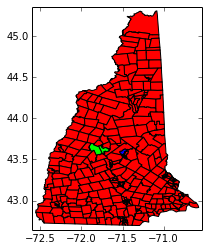

In [11]:
%matplotlib inline
coloring = pd.DataFrame([(f.GEOID10, 0) for f in vtds])
coloring.columns = ['key', 'value']
coloring.value[coloring.key.isin(nodes)] = 1
coloring.value[coloring.key == feature_0.GEOID10] = 2
g = package_vtds(vtdfile)
color_these_states(g, [(coloring, 0)], len(set(coloring.value)))

In [6]:
adjacencyFrame = pd.read_csv('./VTDconnections.csv')
del adjacencyFrame['Unnamed: 0']
adjacencyFrame

,lo,hi,length
0,33001LACO01,33001LACO06,57734.035249
1,33001LACO01,33001LACO03,27641.250204
2,33001LACO01,33001LACO02,9527.047982
3,33001LACO01,33001MERE01,43095.975602
4,33001LACO01,33001GILF01,7850.452278
5,33001LACO06,33001LACO02,10267.333354
6,33001LACO06,33001GILF01,22541.614863
7,33001LACO03,33001LACO02,5370.686762
8,33001LACO03,33001LACO04,17796.860626
9,33001LACO03,33001LACO05,811.836837
